In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error



from keras.layers import Dense, SimpleRNN
from keras.models import Sequential

sns.set_style("white")
%matplotlib inline

# Read Data

In [43]:
data = pd.read_csv('training_set.csv')
charge_attrs = [x for x in data.columns if x.startswith('density')]
agni_attrs = [x for x in data.columns if x.startswith('AGNI')]
ewald_attrs = ['ion-ion repulsion',]

y_col = 'force'
X_cols = charge_attrs + agni_attrs + ewald_attrs
X = data[X_cols].values
y = data[y_col].values

# Base Dense Multilayer NN
Note: Worth running this more epochs on GPU

In [70]:
def time_split(X, y, split):
    X_train = X[0:split]
    X_test = X[split:]

    y_train = y[0:split]
    y_test = y[split:]
    
    return X_train, X_test, y_train, y_test

def composite_predict(models, X):
    preds = []
    for i in range(0, len(models)):
         preds.append(models[i].predict(X))
    composite_pred = np.mean(preds, axis=0) 
    return composite_pred

def keras_rnn_reshape(data, n_pre, n_post):
    dX, dY = [], []
    for i in range(len(data)-n_pre-n_post):
        dX.append(data[i:i+n_pre])
        dY.append(data[i+n_pre:i+n_pre+n_post])
        
    dataX = np.array(dX)
    dataY = np.array(dY)
    return dataX, dataY

## Train-test split data

In [45]:
split = 4725
X_train, X_test, y_train, y_test = time_split(X,y, split)

In [17]:
activation = "linear"

def get_mlp_model(activation="linear"):
    model = Sequential()
    model.add(Dense(512, input_shape=(X.shape[1],), activation=activation))
    model.add(Dense(256, activation=activation))
    model.add(Dense(128, activation=activation))
    model.add(Dense(1, activation=activation))
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    return model

n_models = 1
mlp_models = []
for i in range(0,n_models):
    model = get_mlp_model()
    hist = model.fit(X_train, y_train,epochs=50, batch_size=500, verbose=1)
    mlp_models.append(model)

Epoch 1/50
4725/4725 [==============================] - 0s - loss: 1.5018 - mean_absolute_error: 1.5018     
Epoch 2/50
4725/4725 [==============================] - 0s - loss: 0.9932 - mean_absolute_error: 0.9932     
Epoch 3/50
4725/4725 [==============================] - 0s - loss: 0.5080 - mean_absolute_error: 0.5080     
Epoch 4/50
4725/4725 [==============================] - 0s - loss: 0.3818 - mean_absolute_error: 0.3818     
Epoch 5/50
4725/4725 [==============================] - 0s - loss: 0.2384 - mean_absolute_error: 0.2384     
Epoch 6/50
4725/4725 [==============================] - 0s - loss: 0.1717 - mean_absolute_error: 0.1717     
Epoch 7/50
4725/4725 [==============================] - 0s - loss: 0.1209 - mean_absolute_error: 0.1209     
Epoch 8/50
4725/4725 [==============================] - 0s - loss: 0.1134 - mean_absolute_error: 0.1134     
Epoch 9/50
4725/4725 [==============================] - 0s - loss: 0.1216 - mean_absolute_error: 0.1216     
Epoch 10/50
4725/47

In [46]:
preds = composite_predict(mlp_models,X)
mlp_mae = mean_absolute_error(preds,y)
stopping_power = np.mean(preds)
print("Stopping Power: {} \nMAE: {}".format(stopping_power,mlp_mae))

Stopping Power: 0.23159240186214447 
MAE: 0.07683790061285214


In [47]:
def summary_plots(pred_y, y):
    # Two subplots, unpack the axes array immediately
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.plot(range(0, len(pred_y)), pred_y)
    ax1.plot(range(0, len(pred_y)), y)
    ax1.set_yscale("symlog")
    
    ax2.plot(range(0, len(pred_y)), pred_y)
    ax2.plot(range(0, len(pred_y)), y)
    ax2.set_xlim(7000,9500)
    ax2.set_ylim(-.5,0.9)
    
    sns.despine()
    

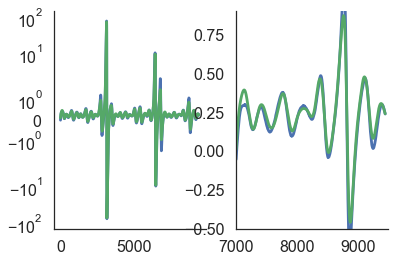

In [48]:
summary_plots(preds, y)

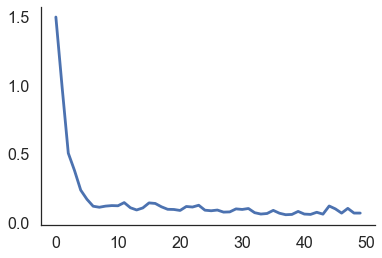

In [54]:
f,ax = plt.subplots()
ax = plt.plot(hist.history['loss'])
sns.despine()

In [18]:
def create_sample_dataset(t, n_dim=2):
    sin = np.sin(2 * np.pi * t)
    cos = np.cos(2 * np.pi * t)
    
    #Stack data into feature columns
    combined = np.column_stack([sin, cos])
    
    #Reshape the data to be
    return combined.reshape((combined.shape[0],n_dim))

def create_lstm_model(steps_before, steps_after, feature_count, hidden_neurons=300):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    model = Sequential()
    model.add(LSTM(input_dim=feature_count, output_dim=hidden_neurons, return_sequences=False))
    model.add(RepeatVector(steps_after))
    model.add(LSTM(output_dim=hidden_neurons, return_sequences=True))
    model.add(TimeDistributed(Dense(feature_count)))
    model.add(Activation('linear'))  
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])  
    return model

def create_gru_model(steps_before, steps_after, feature_count, hidden_neurons=300):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    model = Sequential()
    model.add(GRU(input_dim=feature_count, output_dim=hidden_neurons, return_sequences=False))
    model.add(RepeatVector(steps_after))
    model.add(GRU(output_dim=hidden_neurons, return_sequences=True))
    model.add(TimeDistributed(Dense(feature_count)))
    model.add(Activation('linear'))  
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])  
    return model

In [19]:
def train_model(model, dataX, dataY, epoch_count):
    """ 
        trains only the sinus model
    """
    history = model.fit(dataX, dataY, batch_size=10, epochs=epoch_count, validation_split=0.10)
    return history

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, LSTM, GRU, RepeatVector, Activation

# n_pre = 50
# n_post = 10

n_pre= 50
n_post = 25

n_dim = 2
data = create_sample_dataset(np.arange(0.0, 12.0, 0.02),2)
X,y = keras_rnn_reshape(data, n_pre, n_post)

# # # create and fit the LSTM network
print('creating model...')
models = []
n_models = 3
n_epochs = 10
for i in range(0,n_models):
    print("=== Model -- {} ===".format(i))
    tmp_model = create_lstm_model(n_pre, n_post, 2, 300)
    h = train_model(tmp_model, X, y, n_epochs)
    models.append(tmp_model)

creating model...
=== Model -- 0 ===


/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, input_shape=(None, 2), units=300)`
/home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=300)`


Train on 472 samples, validate on 53 samples
Epoch 1/10
472/472 [==============================] - 8s - loss: 0.1627 - acc: 0.8666 - val_loss: 0.0790 - val_acc: 0.9509
Epoch 2/10
472/472 [==============================] - 7s - loss: 0.0754 - acc: 0.9302 - val_loss: 0.0536 - val_acc: 0.9381
Epoch 3/10
472/472 [==============================] - 7s - loss: 0.0554 - acc: 0.9374 - val_loss: 0.0346 - val_acc: 0.9608
Epoch 4/10
472/472 [==============================] - 7s - loss: 0.0501 - acc: 0.9401 - val_loss: 0.0958 - val_acc: 0.9283
Epoch 5/10
472/472 [==============================] - 7s - loss: 0.0434 - acc: 0.9397 - val_loss: 0.0244 - val_acc: 0.9494
Epoch 6/10
472/472 [==============================] - 7s - loss: 0.0330 - acc: 0.9495 - val_loss: 0.0776 - val_acc: 0.9479
Epoch 7/10
472/472 [==============================] - 7s - loss: 0.0328 - acc: 0.9547 - val_loss: 0.0348 - val_acc: 0.9321
Epoch 8/10
472/472 [==============================] - 7s - loss: 0.0258 - acc: 0.9539 - val_lo

In [29]:
data_test = create_sample_dataset(np.arange(12, 18, 0.02),2)
X_test,y_test = keras_rnn_reshape(data_test, n_pre, n_post)
preds = []
for i in range(0,n_models):
    print(i)
    preds.append(models[i].predict(X_test))
composite_pred = np.mean(preds, axis=0) 

0
1
2


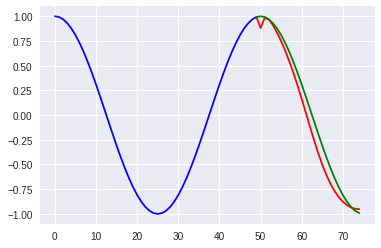

In [30]:
# now plot
nan_array = np.empty((n_pre - 1))
nan_array.fill(np.nan)
nan_array2 = np.empty(n_post)
nan_array2.fill(np.nan)
ind = np.arange(n_pre + n_post)

fig, ax = plt.subplots()
for i in range(0, 50, 50):
    forecasts = np.concatenate((nan_array, X_test[i, -1:, 1], composite_pred[i, :, 1]))
    ground_truth = np.concatenate((nan_array, X_test[i, -1:, 1], y_test[i, :, 1]))
    network_input = np.concatenate((X_test[i, :, 1], nan_array2))

    ax.plot(ind, network_input, 'b-x', label='Network input')
    ax.plot(ind, forecasts, 'r-x', label='Many to many model forecast')
    ax.plot(ind, ground_truth, 'g-x', label = 'Ground truth')

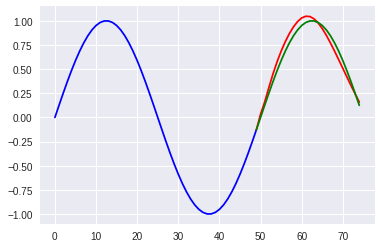

In [31]:
fig, ax = plt.subplots()
for i in range(0, 50, 50):
    forecasts = np.concatenate((nan_array, X_test[i, -1:, 0], composite_pred[i, :, 0]))
    ground_truth = np.concatenate((nan_array, X_test[i, -1:, 0], y_test[i, :, 0]))
    network_input = np.concatenate((X_test[i, :, 0], nan_array2))

    ax.plot(ind, network_input, 'b-x', label='Network input')
    ax.plot(ind, forecasts, 'r-x', label='Many to many model forecast')
    ax.plot(ind, ground_truth, 'g-x', label = 'Ground truth')

In [21]:
from keras.layers import SimpleRNN

In [56]:
data = pd.read_csv('training_set.csv')
charge_attrs = [x for x in data.columns if x.startswith('density')]
agni_attrs = [x for x in data.columns if x.startswith('AGNI')]
ewald_attrs = ['ion-ion repulsion',]
y_col = 'force'
X_cols = charge_attrs + agni_attrs + ewald_attrs

In [57]:
data[y_col].as_matrix().shape

(9449,)

In [58]:
data[X_cols].as_matrix().shape

(9449, 16)

In [59]:
len(X_cols)

16

In [60]:
def create_schleife_model(steps_before, steps_after, hidden_neurons, feature_count):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    out_neurons = 1
    
    model = Sequential()
    model.add(LSTM(input_dim=feature_count, output_dim=hidden_neurons, return_sequences=False))
    model.add(RepeatVector(steps_after))
    #model.add(LSTM(output_dim=hidden_neurons, return_sequences=True))
    model.add(LSTM(output_dim=hidden_neurons, return_sequences=False))
    model.add(Dense(1))
    model.add(Activation('linear'))  
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy']) 
    print(model.summary())
    return model

def create_schleife_single_lstm_model(steps_before, steps_after, hidden_neurons, feature_count):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    out_neurons = 1
    
    model = Sequential()
    model.add(LSTM(input_dim=feature_count, output_dim=hidden_neurons, return_sequences=False))
    model.add(RepeatVector(steps_after))
    model.add(Dense(1))
    model.add(Activation('linear'))  
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy']) 
    print(model.summary())
    return model

def create_schleife_simple_rnn_model2(hidden_neurons, feature_count, activation="relu", steps_after=1):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    out_neurons = 1
    
    model = Sequential()
    model.add(SimpleRNN(units=hidden_neurons, input_dim=feature_count, return_sequences=False, activation=activation))
    model.add(RepeatVector(steps_after))
    model.add(SimpleRNN(units=hidden_neurons, input_dim=feature_count, return_sequences=False, activation=activation))
    model.add(Dense(1))
    
    model.compile(loss='mae', optimizer='rmsprop', metrics=['mae']) 
    print(model.summary())
    return model

def create_schleife_simple_rnn_model(hidden_neurons, feature_count, activation="relu"):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    out_neurons = 1
    
    model = Sequential()
    model.add(SimpleRNN(units=hidden_neurons, input_dim=feature_count, return_sequences=False, activation=activation))
    model.add(Dense(1))
    
    model.compile(loss='mae', optimizer='rmsprop', metrics=['mae']) 
    print(model.summary())
    return model

def keras_schleife_reshape(data_x,data_y, n_pre, n_post):
    dX, dY = [], []
    for i in range(len(data_x)-n_pre-n_post):
        dX.append(data_x[i:i+n_pre])
        dY.append(data_y[i+n_pre:i+n_pre+n_post])

    dataX = np.array(dX)
    dataY = np.array(dY)
    return dataX, dataY

def train_schleife_model(model, dataX, dataY, epoch_count,validation_split=0.1, verbose=False):
    """ 
        trains only the sinus model
    """
    history = model.fit(dataX, dataY, batch_size=200, epochs=epoch_count, validation_split=validation_split, verbose=verbose)
    return history

In [61]:
n_pre= 5
n_post = 1

n_dim = 16

X_ = data[X_cols].as_matrix()
y_ = data[y_col].as_matrix()

X,y = keras_schleife_reshape(X_,y_, n_pre, n_post)

In [62]:
X.shape

(9443, 5, 16)

In [63]:
y.shape

(9443, 1)

In [84]:
# # # create and fit the LSTM network
print('creating model...')
models = []
n_models = 3
n_epochs = 20
for i in range(0,n_models):
    print("=== Model -- {} ===".format(i))
    tmp_model = create_schleife_model(n_pre, n_post, 100, 16)
    h = train_schleife_model(tmp_model, X, y, n_epochs)
    models.append(tmp_model)

creating model...
=== Model -- 0 ===


NameError: name 'LSTM' is not defined

In [65]:
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, SimpleRNN


split = 4725

X_train = X[0:split]
X_test = X[split:]

y_train = y[0:split]
y_test = y[split:]

activation = "linear"

print('creating model...')
models = []
n_models = 1
n_epochs = 20
for i in range(0,n_models):
    print("=== Model -- {} ===".format(i))
    tmp_model = create_schleife_simple_rnn_model2(10, 16, activation="linear")
    h = train_schleife_model(tmp_model, X_train, y_train, n_epochs, validation_split=0.0, verbose=True)
    models.append(tmp_model)

creating model...
=== Model -- 0 ===


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(units=10, return_sequences=False, activation="linear", input_shape=(None, 16))`
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(units=10, return_sequences=False, activation="linear", input_shape=(None, 16))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 10)                270       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 10)             0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
4725/4725 [==============================] - 2s - loss: 0.9940 - mean_absolute_error: 0.9940     
Epoch 2/20
4725/4725 [==============================] - 0s - loss: 0.4866 - mean_absolute_error: 0.4866     
Epoch 3/20
4725/4725 [==============================]

In [71]:
preds = composite_predict(models, X)

# preds = []
# for i in range(0,n_models):
#     print(i)
#     preds.append(models[i].predict(X))
# composite_pred = np.mean(preds, axis=0) 

In [109]:
mean_absolute_error(composite_pred, y)

0.036689993726125726

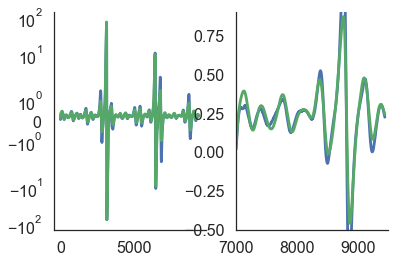

In [73]:
summary_plots(preds, y)

In [75]:
preds = composite_predict(models,X)
mlp_mae = mean_absolute_error(preds,y)
stopping_power = np.mean(preds)
print("Stopping Power: {} \nMAE: {}".format(stopping_power,mlp_mae))

Stopping Power: 0.23045514523983002 
MAE: 0.09728391782097477


(0, 0.2)

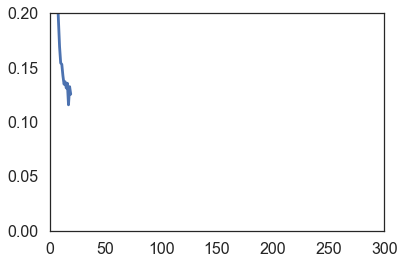

In [76]:
fig, ax = plt.subplots()
ax.plot(h.history['loss'])
ax.set_xlim(0,300)
ax.set_ylim(0,0.2)

In [175]:
# # # create and fit the LSTM network
print('creating model...')
models = []
n_models = 1
n_epochs = 10
for i in range(0,n_models):
    print("=== Model -- {} ===".format(i))
    tmp_model = create_schleife_single_lstm_model(n_pre, n_post, 500, 16)
    h = train_schleife_model(tmp_model, X, y, n_epochs)
    models.append(tmp_model)

creating model...
=== Model -- 0 ===


NameError: name 'LSTM' is not defined

(0, 0.2)

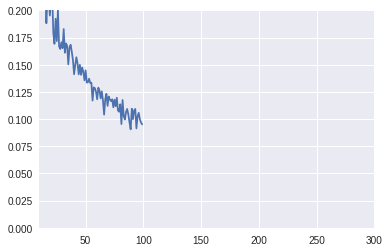